In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Restricted license - for non-production use only - expires 2024-10-28
Obj: 4.5703345390527765
(0, 5)
(5, 6)
(6, 11)
(11, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
from dataset import optDatasetConstrs
# get training and test data set
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test) # without binding constr

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 673.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1278.23it/s]


In [6]:
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train.sols) # with binding constr

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1065.38it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Learning Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    # draw plot
    fig = plt.figure(figsize=(16, 8))
    plt.plot(range(0, num_epochs+1, log_step), regret_log, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
    plt.xticks(range(0, num_epochs+1, log_step), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.title("Learning Curve on Test Set", fontsize=36)
    plt.legend(fontsize=32)
    plt.show()

## Train

### Exact Method 

In [10]:
# init model
reg = LinearRegression()

In [11]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel)

In [12]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [13]:
import time
num_epochs = 20
log_step = 2
loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train:
        x, w, t_ctr = data
        # forward pass
        cp = reg(x)
        loss = ca_cos(cp, t_ctr)
        #loss = torch.sum(cp)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log.append(regret)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
        # print gradients
        #for name, param in reg.named_parameters():
        #    if param.requires_grad:
        #        print(f"Gradient of {name}: {param.grad}")
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  -0.9972, Regret: 28.5068%
Epoch   2, Loss:  -0.9966, Regret: 12.2269%
Epoch   4, Loss:  -0.9999, Regret:  6.2399%
Epoch   6, Loss:  -1.0000, Regret:  3.7113%
Epoch   8, Loss:  -1.0000, Regret:  3.0097%
Epoch  10, Loss:  -1.0000, Regret:  2.6737%
Epoch  12, Loss:  -0.9999, Regret:  2.5079%
Epoch  14, Loss:  -1.0000, Regret:  1.8953%
Epoch  16, Loss:  -1.0000, Regret:  1.8329%
Epoch  18, Loss:  -1.0000, Regret:  1.5127%
Elapsed Time: 1187.61 Sec


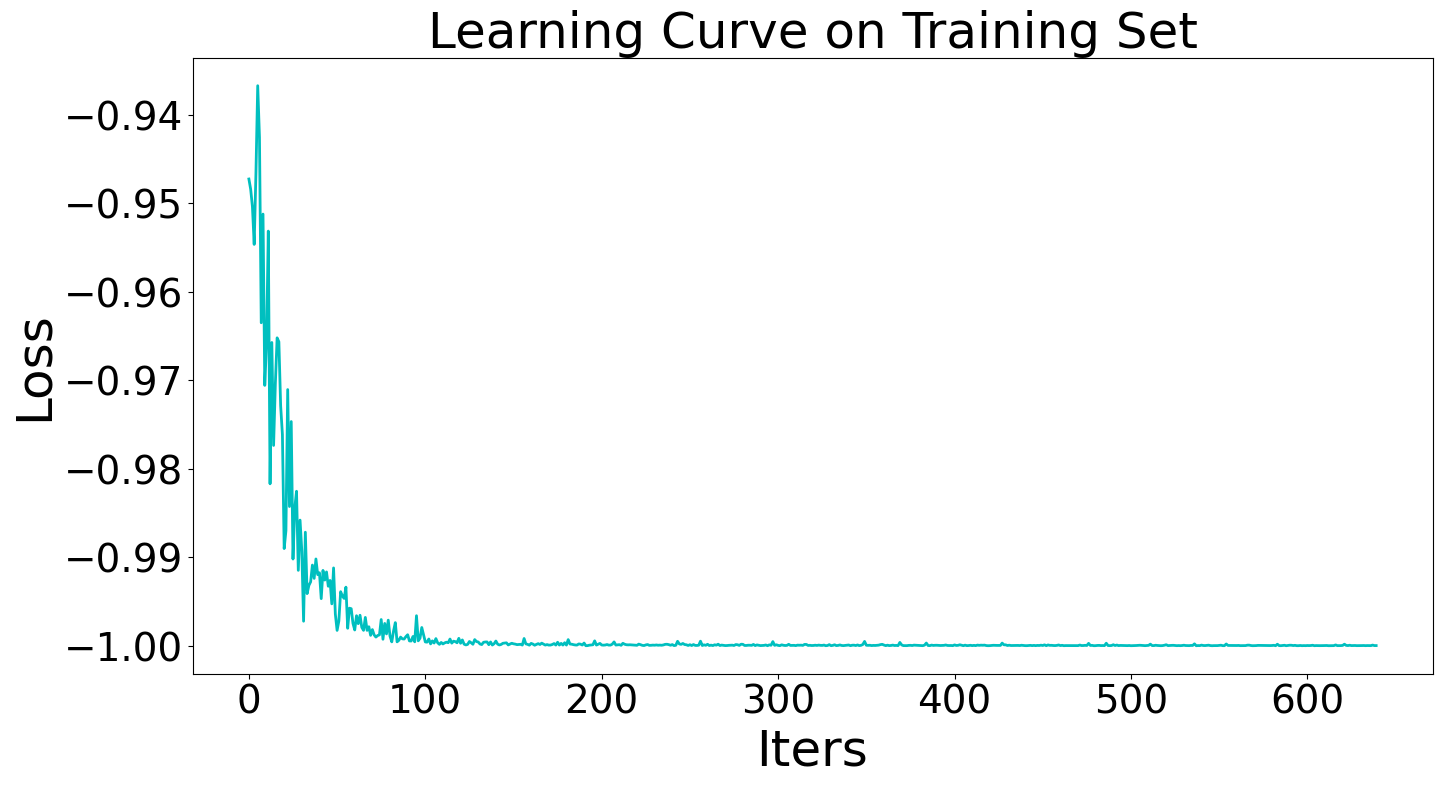

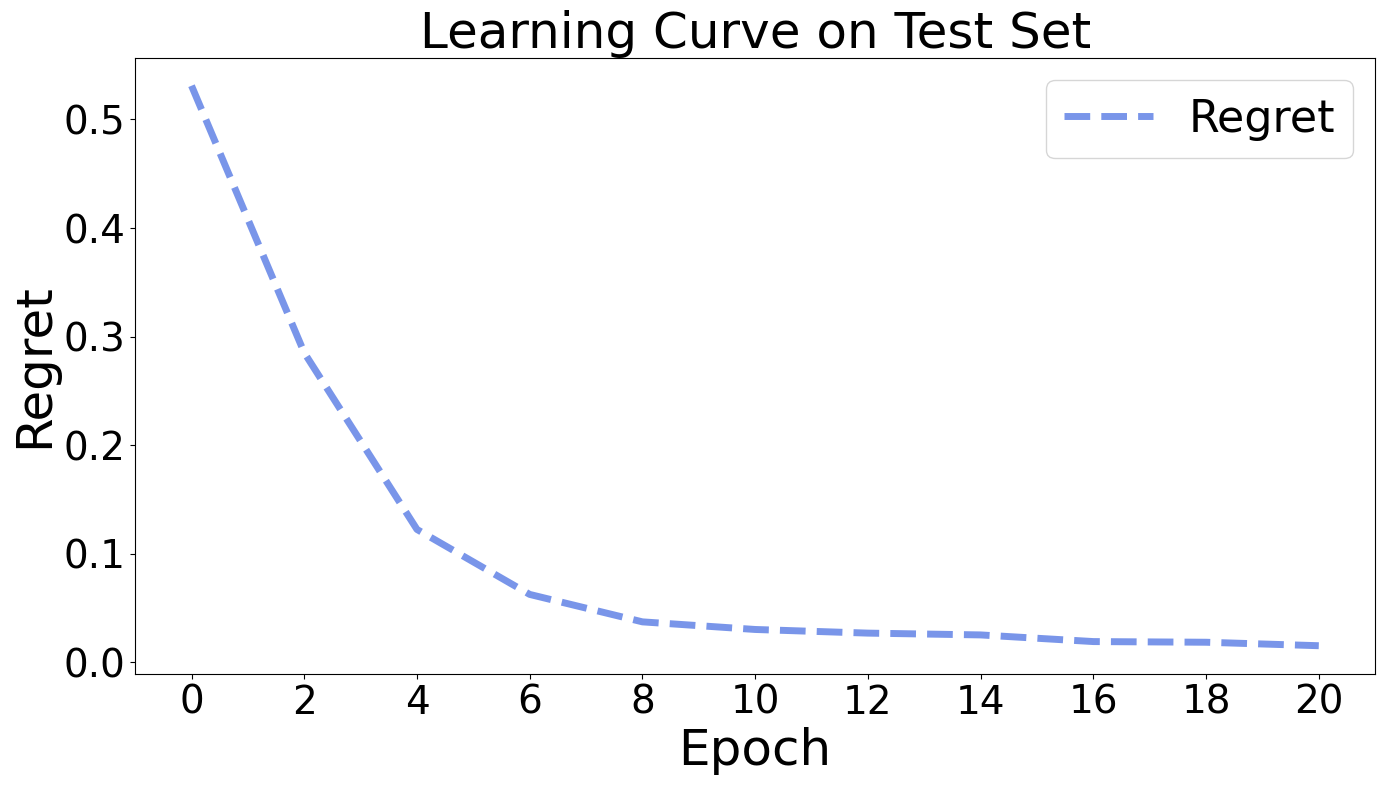

In [14]:
plot(loss_log, regret_log, num_epochs, log_step)

###  Base Vector Method

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import baseVectConeAlignedCosine
# init loss
ca_cos = baseVectConeAlignedCosine(optmodel)

In [17]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [18]:
import time
num_epochs = 20
log_step = 2
loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train:
        x, w, t_ctr = data
        # forward pass
        cp = reg(x)
        loss = ca_cos(cp, t_ctr)
        #loss = torch.sum(cp)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log.append(regret)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
        # print gradients
        #for name, param in reg.named_parameters():
        #    if param.requires_grad:
        #        print(f"Gradient of {name}: {param.grad}")
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  -0.5354, Regret: 46.7230%
Epoch   2, Loss:  -0.8491, Regret: 44.2061%
Epoch   4, Loss:  -0.8448, Regret: 48.3043%
Epoch   6, Loss:  -0.8568, Regret: 38.3003%
Epoch   8, Loss:  -0.9156, Regret: 51.7948%
Epoch  10, Loss:  -0.9446, Regret: 38.4835%
Epoch  12, Loss:  -0.8646, Regret: 40.3699%
Epoch  14, Loss:  -0.9013, Regret: 33.2955%
Epoch  16, Loss:  -0.9389, Regret: 50.0705%
Epoch  18, Loss:  -0.9952, Regret: 44.6021%
Elapsed Time: 3.67 Sec


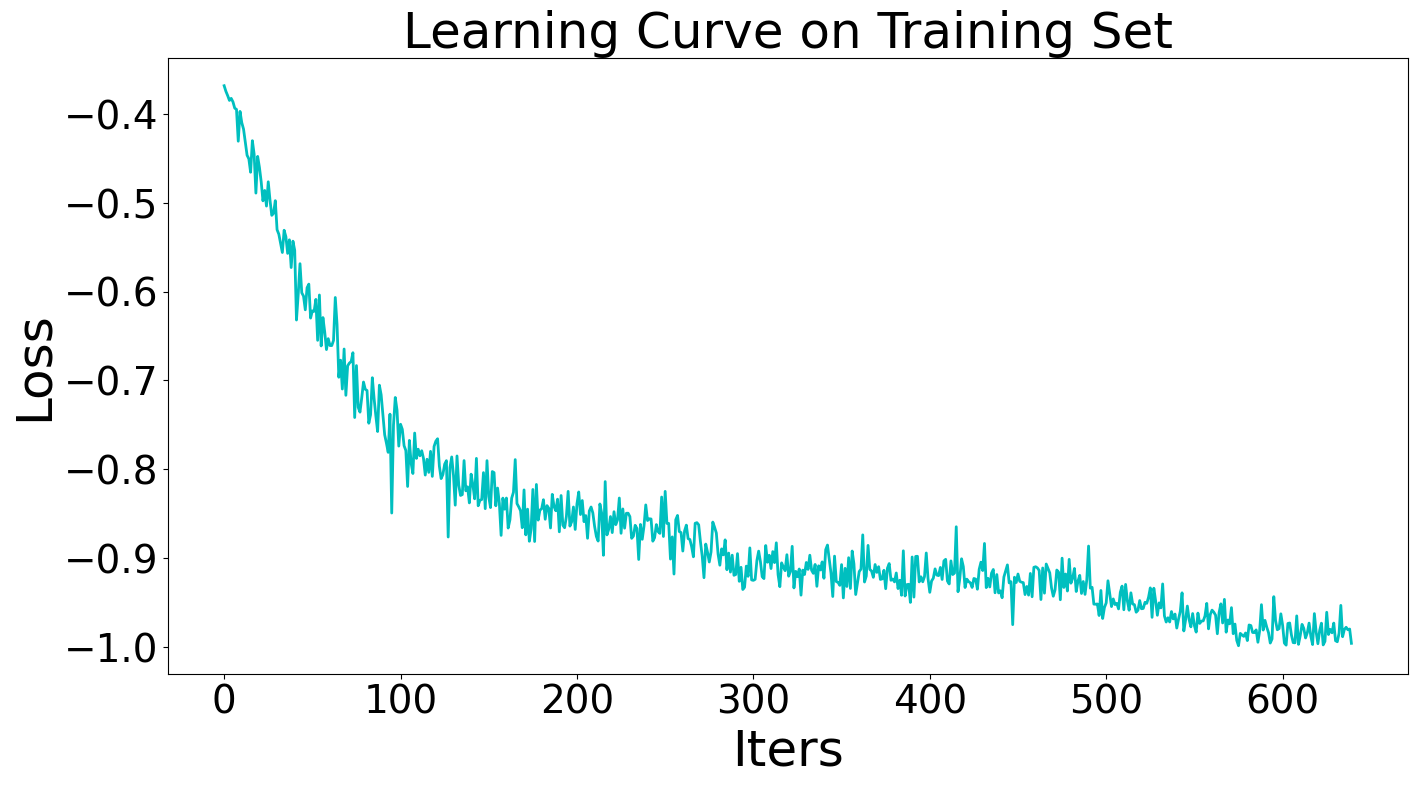

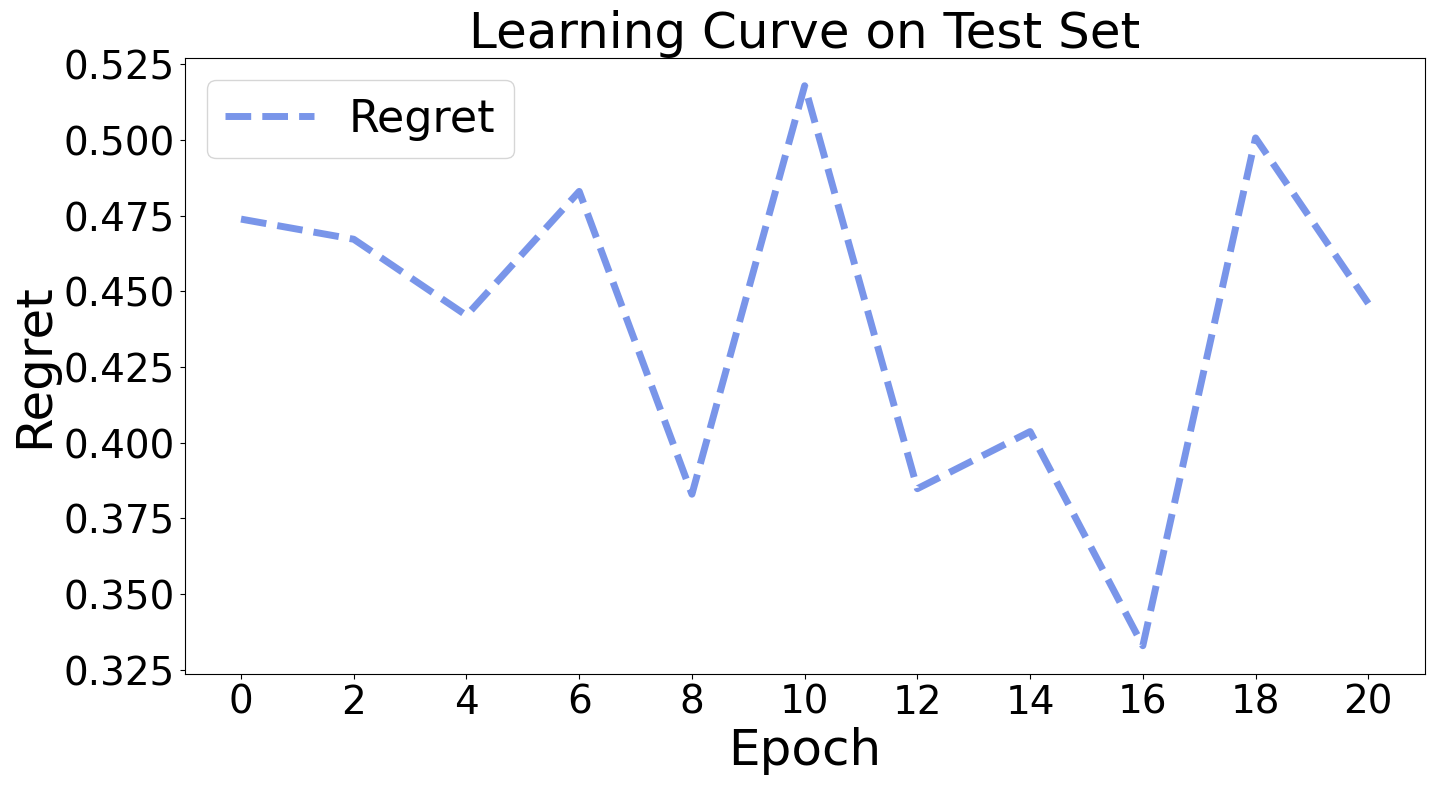

In [19]:
plot(loss_log, regret_log, num_epochs, log_step)

### Sampling Method

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [22]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [23]:
import time
num_epochs = 20
log_step = 2
loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train:
        x, w, t_ctr = data
        # forward pass
        cp = reg(x)
        loss = ca_cos(cp, t_ctr)
        #loss = torch.sum(cp)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log.append(regret)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
        # print gradients
        #for name, param in reg.named_parameters():
        #    if param.requires_grad:
        #        print(f"Gradient of {name}: {param.grad}")
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  -0.5085, Regret: 22.9168%
Epoch   2, Loss:  -0.6467, Regret:  4.7058%
Epoch   4, Loss:  -0.6817, Regret:  2.7704%
Epoch   6, Loss:  -0.6507, Regret:  2.8840%
Epoch   8, Loss:  -0.6697, Regret:  2.7787%
Epoch  10, Loss:  -0.6906, Regret:  2.7808%
Epoch  12, Loss:  -0.6981, Regret:  2.8439%
Epoch  14, Loss:  -0.6970, Regret:  2.7937%
Epoch  16, Loss:  -0.6932, Regret:  2.4525%
Epoch  18, Loss:  -0.6737, Regret:  2.9473%
Elapsed Time: 6.43 Sec


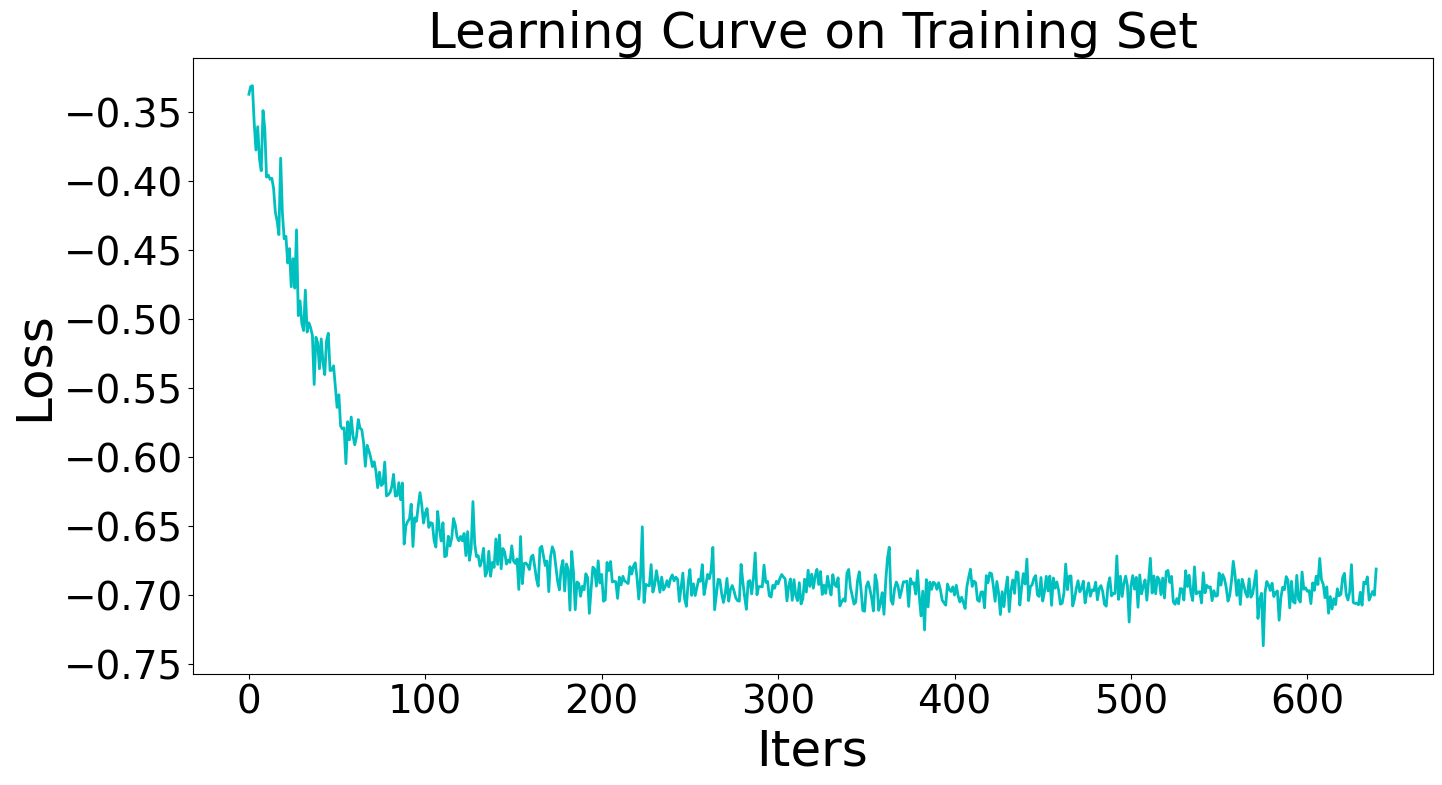

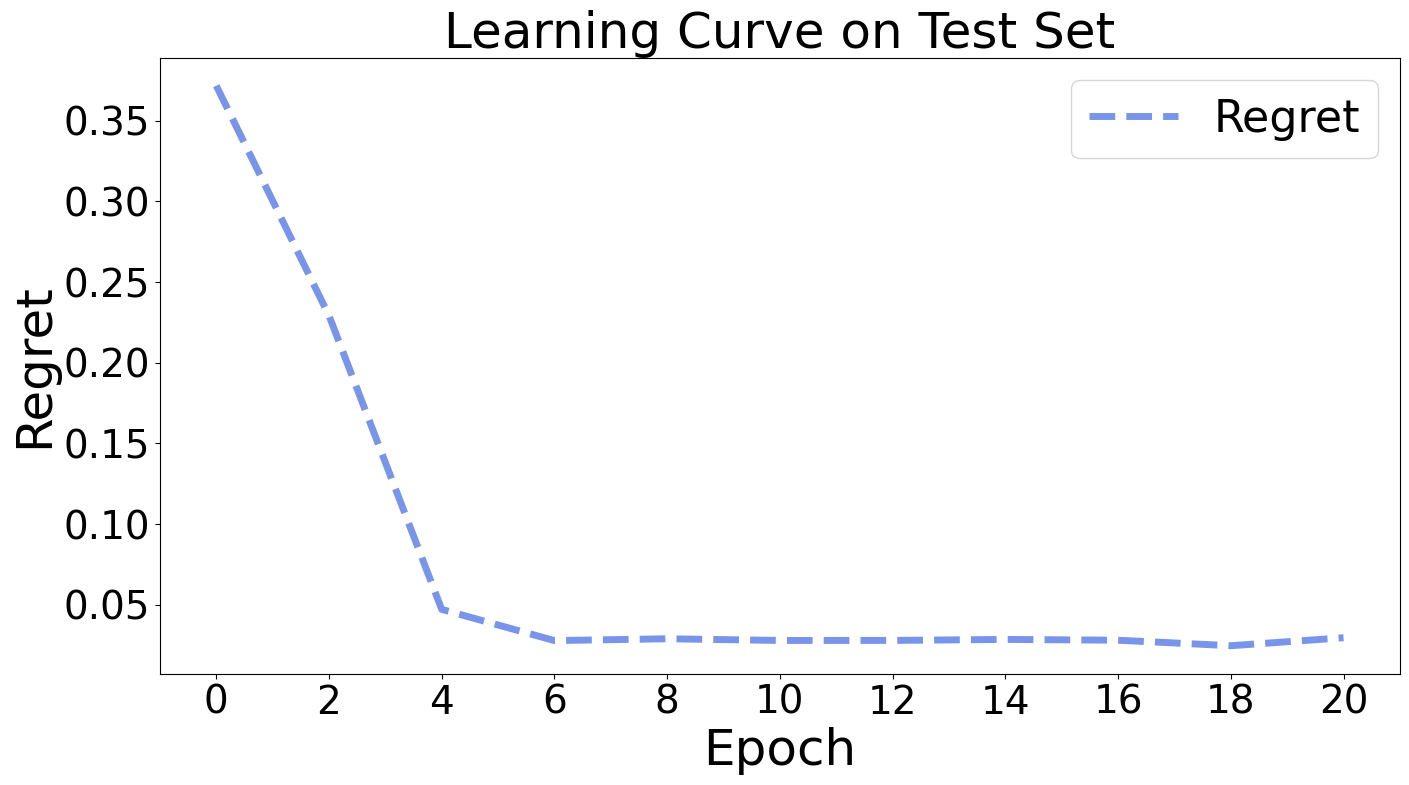

In [24]:
plot(loss_log, regret_log, num_epochs, log_step)